# "Beating the market with the simple possible predictive metric."

This is an implementation of algorithm from https://www.reddit.com/r/algotrading/comments/mtp8b5/beating_the_market_with_the_simple_possible/ using [universal-portfolios](https://github.com/Marigold/universal-portfolios) package.

Note that this is just a demonstration how to use the package and replicate the results, it's not meant as a real analysis and it's likely wrong.

In [1]:
# some init stuff
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

sns.set_context("notebook")
plt.rcParams["figure.figsize"] = (16, 8)

# Get data

In [2]:
# nasdaq 100 as of 2021-08-18
nasdaq100 = [
"AAPL",
"MSFT",
"AMZN",
"GOOG",
"FB",
"TSLA",
"NVDA",
"PYPL",
"ADBE",
"CMCSA",
"CSCO",
"NFLX",
"PEP",
"INTC",
"COST",
"AVGO",
"TMUS",
"TXN",
"QCOM",
"MRNA",
"HON",
"CHTR",
"INTU",
"SBUX",
"AMGN",
"AMD",
"ISRG",
"AMAT",
"GILD",
"ADP",
"MDLZ",
"MELI",
"BKNG",
"LRCX",
"ZM",
"MU",
"CSX",
"ILMN",
"FISV",
"ADSK",
"REGN",
"ATVI",
"ASML",
"ADI",
"IDXX",
"NXPI",
"DOCU",
"ALGN",
"BIIB",
"JD",
"MNST",
"VRTX",
"EBAY",
"KLAC",
"DXCM",
"KDP",
"LULU",
"MRVL",
"EXC",
"KHC",
"TEAM",
"AEP",
"SNPS",
"WDAY",
"ROST",
"WBA",
"MAR",
"PAYX",
"ORLY",
"CDNS",
"CTAS",
"CTSH",
"EA",
"MCHP",
"XEL",
"BIDU",
"MTCH",
"XLNX",
"CPRT",
"FAST",
"VRSK",
"ANSS",
"PTON",
"PDD",
"SWKS",
"SGEN",
"OKTA",
"PCAR",
"CDW",
"MXIM",
"NTES",
"SIRI",
"CERN",
"VRSN",
"SPLK",
"DLTR",
"INCY",
"CHKP",
"TCOM",
"FOX",
]

import pandas_datareader.data as web
S = []
# loading data in chunks from yahoo is more robust than loading everything at once
for i, chunk in enumerate(np.array_split(nasdaq100, 10)):
    print(f'Loading chunk {i}')
    # 2010-01-01 is arbitrary
    S.append(web.DataReader(chunk, 'yahoo', start='2010-01-01', end='2021-08-17')['Adj Close'])
    
S = pd.concat(S, axis=1)

Loading chunk 0
Loading chunk 1
Loading chunk 2
Loading chunk 3
Loading chunk 4
Loading chunk 5
Loading chunk 6
Loading chunk 7
Loading chunk 8
Loading chunk 9


# Construct weights for momentum & reversal strategies

Momentum strategy goes long stock with the highest yesterday return, reversal goes long stock with the lowest yesterday return.

Construct weight matrices for CRP "algorithm" that just allocates portfolio based on given weights.

In [11]:
from universal.algos import CRP

# find best performing and worst performing stock
R = S / S.shift(1)
highest_return_symbol = R.idxmax(axis=1).shift(1)
lower_return_symbol = R.idxmin(axis=1).shift(1)

# construct weights
W_mom = S * 0
for col in R.columns:
    W_mom.loc[highest_return_symbol == col, col] = 1

W_rev = S * 0
for col in R.columns:
    W_rev.loc[lower_return_symbol == col, col] = 1

Summary:
    Profit factor: 0.97
    Sharpe ratio: 0.06 ± 0.29
    Ulcer index: 0.05
    Information ratio (wrt UCRP): -0.49
    UCRP sharpe: 1.36 ± 0.41
    Appraisal ratio (wrt UCRP): -0.48 ± 0.29
    Beta / Alpha: 0.98 / -22.686%
    Annualized return: 3.12%
    Annualized volatility: 50.97%
    Longest drawdown: 2484 days
    Max drawdown: 89.01%
    Winning days: 49.0%
    Annual turnover: 466.4
        


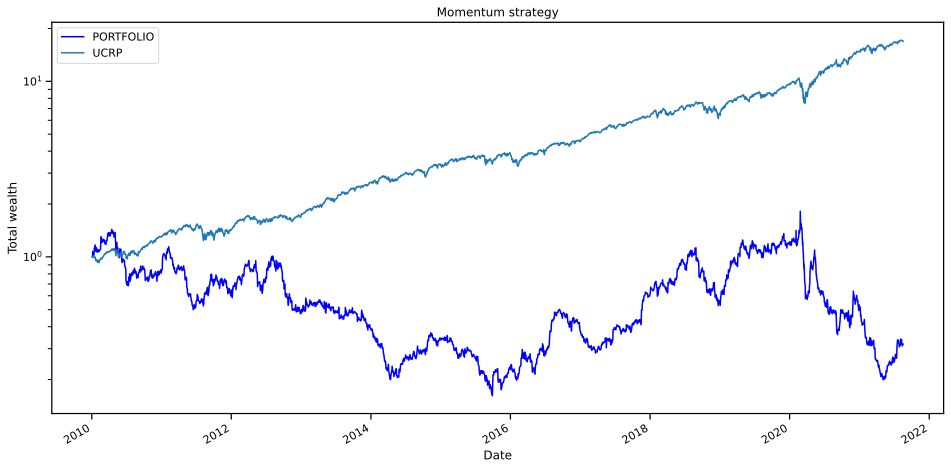

In [12]:
# keep graphs simple
plot_kwargs = {
    "logy": True,
    "assets": False,
    "weights": False,
    "ucrp": True,
}

algo = CRP(W_mom)
result = algo.run(S)
print(result.summary())
result.plot(**plot_kwargs, title='Momentum strategy')
r_mom = result.r_log

Summary:
    Profit factor: 1.04
    Sharpe ratio: 0.45 ± 0.31
    Ulcer index: 0.59
    Information ratio (wrt UCRP): -0.04
    UCRP sharpe: 1.36 ± 0.41
    Appraisal ratio (wrt UCRP): -0.12 ± 0.29
    Beta / Alpha: 1.15 / -5.719%
    Annualized return: 24.41%
    Annualized volatility: 53.75%
    Longest drawdown: 1651 days
    Max drawdown: 79.64%
    Winning days: 51.4%
    Annual turnover: 495.8
        


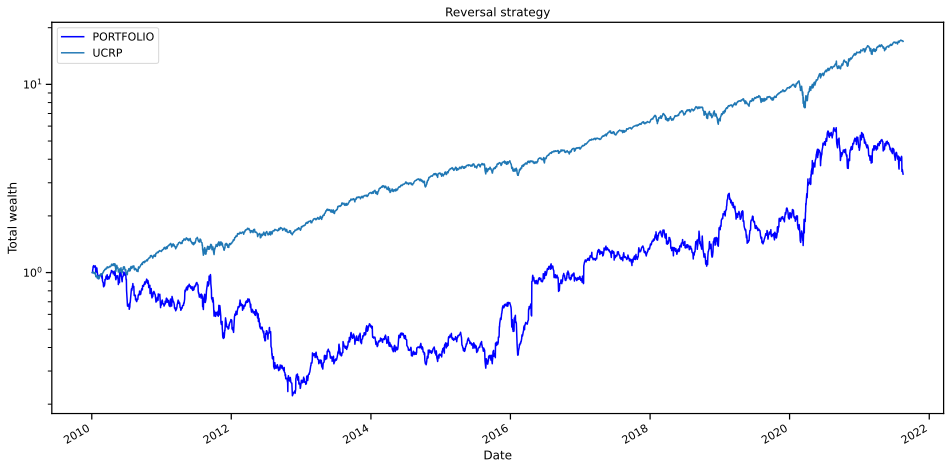

In [13]:
algo = CRP(W_rev)
result = algo.run(S)
print(result.summary())
result.plot(**plot_kwargs, title='Reversal strategy')
r_rev = result.r_log

# Combined strategy

<AxesSubplot:xlabel='Date'>

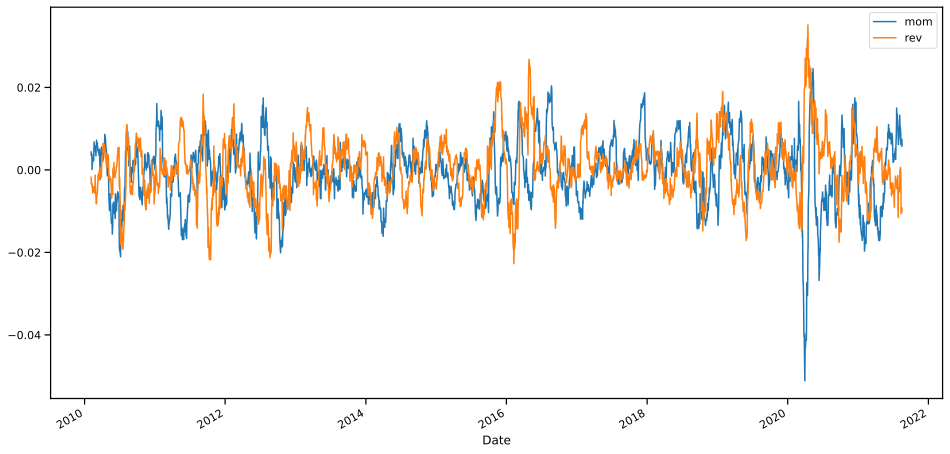

In [17]:
# get recent performance, e.g. last 22 days
PERIOD = 22
performance = pd.DataFrame({
    'mom': r_mom.rolling(PERIOD).mean(),
    'rev': r_rev.rolling(PERIOD).mean(),
})

# shift performance by 1 day to avoid lookahead bias
performance = performance.shift(1)

# plot performance
performance.plot()

In [18]:
# construct new weight matrix from momentum and reversal
mom_better = (performance.mom > performance.rev)
rev_better = (performance.rev > performance.mom)
W = W_mom.mul(mom_better, axis=0) + W_rev.mul(rev_better, axis=0)

print(f'Momentum is better {mom_better.mean():.2%} of time')
print(f'Reversal is better {rev_better.mean():.2%} of time')

# fill the rest with uniform weights so that it's comparable to UCRP
W.iloc[:PERIOD, :] = 1./100

Momentum is better 47.95% of time
Reversal is better 51.30% of time


Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.56 ± 0.32
    Ulcer index: 0.78
    Information ratio (wrt UCRP): 0.08
    UCRP sharpe: 1.36 ± 0.41
    Appraisal ratio (wrt UCRP): 0.01 ± 0.29
    Beta / Alpha: 1.14 / 0.258%
    Annualized return: 30.05%
    Annualized volatility: 53.40%
    Longest drawdown: 1234 days
    Max drawdown: 77.98%
    Winning days: 50.4%
    Annual turnover: 477.2
        


[<AxesSubplot:title={'center':'Combined strategy'}, xlabel='Date', ylabel='Total wealth'>]

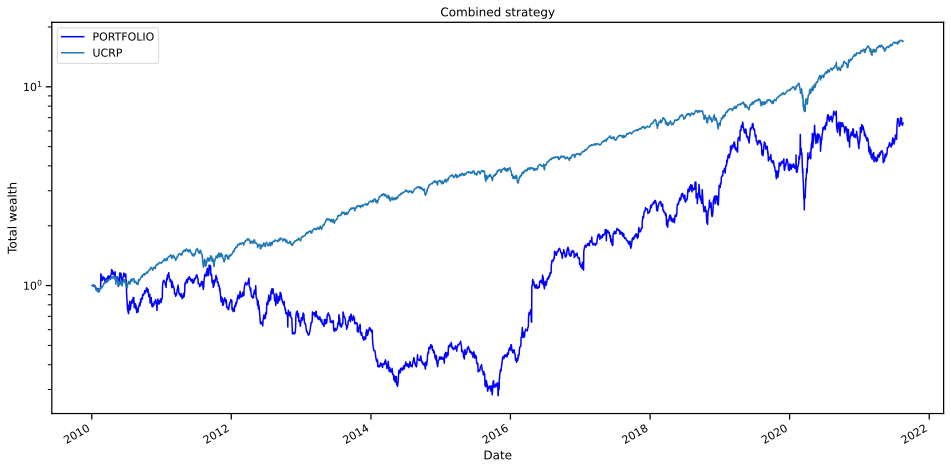

In [19]:
# final combined strategy
algo = CRP(W)
result = algo.run(S)
print(result.summary())
result.plot(logy=True, assets=False, weights=False, ucrp=True, title='Combined strategy')

# Summary

Beating nasdaq in the last 10 years is IMHO nearly impossible. The post on reddit was published 4 months ago and goes approx 3 years into history. That corresponds to the right part of equity that goes straight up (still, its sharpe ratio is lower than that of Nasdaq 100). Period from 2010 to 2016 is disappointing. Has the strategy started working because of the rise of retail trading? Or is it simply data mining that doesn't work out-of-sample?

Note that the above analysis is without fees which could be high because of high annual turnover.